<h1>Assesment Question:</h1>
<p>1- How are blood donations in Malaysia / states trending?</p>
<p>2- How well is Malaysia retaining blood donors? (meaning, are people with a history of blood donation coming back to donate regularly)</p>

And after creating data visualisation for answering this questions, we will need to use Telegram bot API to post a message in a group daily

Question in mind:
1. What visualisation that are useful for daily updates? Or is it sufficient enough to use a visualisation 

In [71]:
from git import Repo
import os
import requests

import pandas as pd 
import numpy as np 
import pyarrow.parquet as pq
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt 
import seaborn as sns

import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

<h1>Question 1</h1>
<p>Planning:</p>
<p>1. Chloropleth on Donation Distribtion for every State</p>
<p>2. Sankey Diagram 3 Level (State->Hospital->Type of Blood)</p>
<p>2. Time-Series Plot</p>

Mainly I Will use data from donations_facility.csv . Since Data of Newdonors are in Age, we can create extra visualisation to show age trend

In [72]:
facility_df = pd.read_csv('.\data_aggregate\donations_facility.csv')
facility_df.head(5)

,date,hospital,daily,blood_a,blood_b,blood_o,blood_ab,location_centre,location_mobile,type_wholeblood,type_apheresis_platelet,type_apheresis_plasma,type_other,social_civilian,social_student,social_policearmy,donations_new,donations_regular,donations_irregular
0,2006-01-01,Hospital Sultanah Nora Ismail,87,19,20,45,3,87,0,87,0,0,0,86,1,0,36,49,2
1,2006-01-01,Hospital Sultanah Aminah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2006-01-01,Hospital Sultanah Bahiyah,208,67,62,61,18,208,0,208,0,0,0,197,8,3,1,207,0
3,2006-01-01,Hospital Raja Perempuan Zainab II,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2006-01-01,Hospital Melaka,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0


In [73]:
#getting the list of facilities
list(facility_df['hospital'].unique())

['Hospital Sultanah Nora Ismail',
 'Hospital Sultanah Aminah',
 'Hospital Sultanah Bahiyah',
 'Hospital Raja Perempuan Zainab II',
 'Hospital Melaka',
 'Hospital Tuanku Jaafar',
 'Hospital Tengku Ampuan Afzan',
 'Hospital Sultan Haji Ahmad Shah',
 'Hospital Seberang Jaya',
 'Hospital Pulau Pinang',
 'Hospital Raja Permaisuri Bainun',
 'Hospital Taiping',
 'Hospital Seri Manjung',
 'Hospital Tengku Ampuan Rahimah',
 'Hospital Sultanah Nur Zahirah',
 'Hospital Queen Elizabeth II',
 'Hospital Duchess Of Kent',
 'Hospital Tawau',
 'Hospital Umum Sarawak',
 'Hospital Miri',
 'Hospital Sibu',
 'Pusat Darah Negara']

In [74]:
# Manually Map the list of hospital to their state
hospital_state = {
    'Hospital Sultanah Nora Ismail': 'Johor',
    'Hospital Sultanah Aminah': 'Johor',
    'Hospital Sultanah Bahiyah': 'Kedah',
    'Hospital Raja Perempuan Zainab II': 'Kelantan',
    'Hospital Melaka': 'Melaka',
    'Hospital Tuanku Jaafar': 'Negeri Sembilan',
    'Hospital Tengku Ampuan Afzan': 'Pahang',
    'Hospital Sultan Haji Ahmad Shah': 'Pahang',
    'Hospital Seberang Jaya': 'Penang',
    'Hospital Pulau Pinang': 'Penang',
    'Hospital Raja Permaisuri Bainun': 'Perak',
    'Hospital Taiping': 'Perak',
    'Hospital Seri Manjung': 'Perak',
    'Hospital Tengku Ampuan Rahimah': 'Selangor',
    'Hospital Sultanah Nur Zahirah': 'Terengganu',
    'Hospital Queen Elizabeth II': 'Sabah',
    'Hospital Duchess Of Kent': 'Sabah',
    'Hospital Tawau': 'Sabah',
    'Hospital Umum Sarawak': 'Sarawak',
    'Hospital Miri': 'Sarawak',
    'Hospital Sibu': 'Sarawak',
    'Pusat Darah Negara': 'Kuala Lumpur'
}

#Add another column to the dataframe
facility_df['state'] = facility_df['hospital'].map(hospital_state)
facility_df

,date,hospital,daily,blood_a,blood_b,blood_o,blood_ab,location_centre,location_mobile,type_wholeblood,type_apheresis_platelet,type_apheresis_plasma,type_other,social_civilian,social_student,social_policearmy,donations_new,donations_regular,donations_irregular,state
0,2006-01-01,Hospital Sultanah Nora Ismail,87,19,20,45,3,87,0,87,0,0,0,86,1,0,36,49,2,Johor
1,2006-01-01,Hospital Sultanah Aminah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Johor
2,2006-01-01,Hospital Sultanah Bahiyah,208,67,62,61,18,208,0,208,0,0,0,197,8,3,1,207,0,Kedah
3,2006-01-01,Hospital Raja Perempuan Zainab II,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Kelantan
4,2006-01-01,Hospital Melaka,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,Melaka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145107,2024-01-22,Hospital Tawau,10,3,1,5,1,10,0,10,0,0,0,9,0,1,0,7,3,Sabah
145108,2024-01-22,Hospital Umum Sarawak,29,4,8,17,0,29,0,29,0,0,0,27,2,0,2,26,1,Sarawak
145109,2024-01-22,Hospital Miri,12,2,6,4,0,12,0,12,0,0,0,11,1,0,0,12,0,Sarawak
145110,2024-01-22,Hospital Sibu,9,2,3,4,0,9,0,9,0,0,0,9,0,0,0,8,1,Sarawak


In [75]:
#Filter the data by last 3 months
facility_df['date']= pd.to_datetime(facility_df['date']) # set the column data type into pandas datetime
last_3_months = max(facility_df['date'])-pd.Timedelta(days=90)
last3_df = facility_df[facility_df['date']>=last_3_months]
last3_df

,date,hospital,daily,blood_a,blood_b,blood_o,blood_ab,location_centre,location_mobile,type_wholeblood,type_apheresis_platelet,type_apheresis_plasma,type_other,social_civilian,social_student,social_policearmy,donations_new,donations_regular,donations_irregular,state
143110,2023-10-24,Hospital Sultanah Nora Ismail,10,2,3,5,0,10,0,10,0,0,0,10,0,0,2,6,2,Johor
143111,2023-10-24,Hospital Sultanah Aminah,84,20,27,31,6,22,62,84,0,0,0,77,6,1,24,37,23,Johor
143112,2023-10-24,Hospital Sultanah Bahiyah,44,8,6,25,5,13,31,44,0,0,0,23,20,1,20,18,6,Kedah
143113,2023-10-24,Hospital Raja Perempuan Zainab II,52,17,11,21,3,12,40,52,0,0,0,46,5,1,18,27,7,Kelantan
143114,2023-10-24,Hospital Melaka,13,1,3,9,0,13,0,12,1,0,0,11,1,1,2,10,1,Melaka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145107,2024-01-22,Hospital Tawau,10,3,1,5,1,10,0,10,0,0,0,9,0,1,0,7,3,Sabah
145108,2024-01-22,Hospital Umum Sarawak,29,4,8,17,0,29,0,29,0,0,0,27,2,0,2,26,1,Sarawak
145109,2024-01-22,Hospital Miri,12,2,6,4,0,12,0,12,0,0,0,11,1,0,0,12,0,Sarawak
145110,2024-01-22,Hospital Sibu,9,2,3,4,0,9,0,9,0,0,0,9,0,0,0,8,1,Sarawak


In [76]:
#group by state
state3_df = last3_df.groupby('state')['daily'].sum().reset_index(name='total_donation')
state3_df 

,state,total_donation
0,Johor,11337
1,Kedah,5408
2,Kelantan,4300
3,Kuala Lumpur,49438
4,Melaka,6836
5,Negeri Sembilan,4296
6,Pahang,5490
7,Penang,9413
8,Perak,10859
9,Sabah,10199


In [77]:
#link geojson = https://cartographyvectors.com/map/1477-malaysia-with-regions
gdf = gpd.read_file('malaysia-with-regions_.geojson')
gdf

,id,name,density,path,geometry
0,5871,Federal Territory of Kuala Lumpur,0,/world/Malaysia/Federal Territory of Kuala Lumpur,"MULTIPOLYGON (((101.63830 3.22810, 101.66559 3..."
1,5874,Federal Territory of Putrajaya,0,/world/Malaysia/Federal Territory of Putrajaya,"MULTIPOLYGON (((101.67933 2.97116, 101.68001 2..."
2,5878,Johor,0,/world/Malaysia/Johor,"MULTIPOLYGON (((103.63678 2.65774, 103.65669 2..."
3,5875,Kedah,0,/world/Malaysia/Kedah,"MULTIPOLYGON (((100.33882 5.57806, 100.33058 5..."
4,5879,Kelantan,0,/world/Malaysia/Kelantan,"MULTIPOLYGON (((102.09183 6.23886, 102.16461 6..."
5,5880,Melaka,0,/world/Malaysia/Melaka,"MULTIPOLYGON (((102.48837 2.09912, 102.47412 2..."
6,5881,Negeri Sembilan,0,/world/Malaysia/Negeri Sembilan,"MULTIPOLYGON (((101.97475 2.38986, 101.97166 2..."
7,5882,Pahang,0,/world/Malaysia/Pahang,"MULTIPOLYGON (((103.42117 4.17557, 103.40195 4..."
8,5877,Penang,0,/world/Malaysia/Penang,"MULTIPOLYGON (((100.39513 5.12685, 100.42602 5..."
9,5883,Perak,0,/world/Malaysia/Perak,"MULTIPOLYGON (((100.81535 3.84987, 100.76111 3..."


In [78]:
gdf.drop(columns=['id','density','path'],axis=1,inplace=True)#drop col
gdf.drop(index=[1,10],inplace=True)#drop Perlis and Putrajaya
gdf.loc[0,'name'] = 'Kuala Lumpur' #rename Wilayah KL to Kuala Lumpur
gdf.sort_values(by='name',inplace=True) #Sort by name
gdf.reset_index(inplace=True,drop=True)#reset index

In [79]:
gdf

,name,geometry
0,Johor,"MULTIPOLYGON (((103.63678 2.65774, 103.65669 2..."
1,Kedah,"MULTIPOLYGON (((100.33882 5.57806, 100.33058 5..."
2,Kelantan,"MULTIPOLYGON (((102.09183 6.23886, 102.16461 6..."
3,Kuala Lumpur,"MULTIPOLYGON (((101.63830 3.22810, 101.66559 3..."
4,Melaka,"MULTIPOLYGON (((102.48837 2.09912, 102.47412 2..."
5,Negeri Sembilan,"MULTIPOLYGON (((101.97475 2.38986, 101.97166 2..."
6,Pahang,"MULTIPOLYGON (((103.42117 4.17557, 103.40195 4..."
7,Penang,"MULTIPOLYGON (((100.39513 5.12685, 100.42602 5..."
8,Perak,"MULTIPOLYGON (((100.81535 3.84987, 100.76111 3..."
9,Sabah,"MULTIPOLYGON (((115.40588 4.96509, 115.55420 5..."


In [80]:
state3_df_merged = gdf.merge(state3_df, how='left', left_on='name', right_on='state')
state3_df_merged=state3_df_merged.iloc[:,1:]
state3_df_merged

,geometry,state,total_donation
0,"MULTIPOLYGON (((103.63678 2.65774, 103.65669 2...",Johor,11337
1,"MULTIPOLYGON (((100.33882 5.57806, 100.33058 5...",Kedah,5408
2,"MULTIPOLYGON (((102.09183 6.23886, 102.16461 6...",Kelantan,4300
3,"MULTIPOLYGON (((101.63830 3.22810, 101.66559 3...",Kuala Lumpur,49438
4,"MULTIPOLYGON (((102.48837 2.09912, 102.47412 2...",Melaka,6836
5,"MULTIPOLYGON (((101.97475 2.38986, 101.97166 2...",Negeri Sembilan,4296
6,"MULTIPOLYGON (((103.42117 4.17557, 103.40195 4...",Pahang,5490
7,"MULTIPOLYGON (((100.39513 5.12685, 100.42602 5...",Penang,9413
8,"MULTIPOLYGON (((100.81535 3.84987, 100.76111 3...",Perak,10859
9,"MULTIPOLYGON (((115.40588 4.96509, 115.55420 5...",Sabah,10199


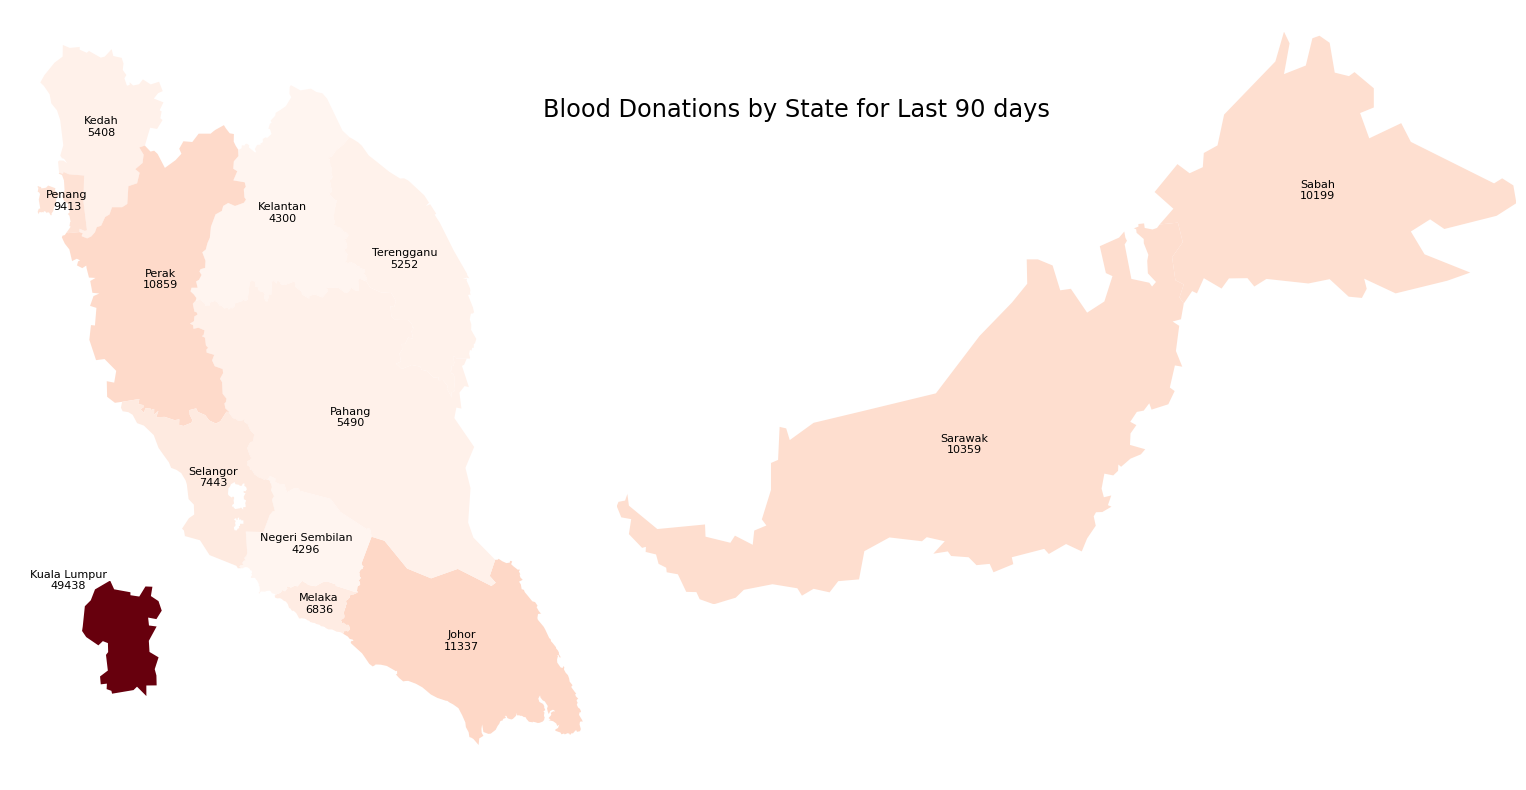

In [99]:
# Normalize Total Donation 
vmin, vmax = state3_df_merged['total_donation'].min(), state3_df_merged['total_donation'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
colour_gradient = 'Reds'

# Create the main plot for Peninsular Malaysia excluding Kuala Lumpur for clarity
fig, ax_main = plt.subplots(figsize=(10, 10))
plt.text(x=104,y=6,s = 'Blood Donations by State for Last 90 days',fontsize = 'xx-large')
peninsular_without_kl = state3_df_merged[(state3_df_merged['state'] != 'Sabah') & (state3_df_merged['state'] != 'Sarawak') & (state3_df_merged['state'] != 'Kuala Lumpur')]
peninsular_without_kl.plot(column='total_donation', ax=ax_main, cmap=colour_gradient, norm=norm)

# Create an inset for Sabah and Sarawak
ax_sabah_sarawak = inset_axes(ax_main, width="150%", height="150%", loc='center left',
                               bbox_to_anchor=(1, 0.1, 1, 1), bbox_transform=ax_main.transAxes)
sabah_sarawak = state3_df_merged[(state3_df_merged['state'] == 'Sabah') | (state3_df_merged['state'] == 'Sarawak')]
sabah_sarawak.plot(column='total_donation', ax=ax_sabah_sarawak, cmap=colour_gradient,norm=norm)

# Adjust Sabah and Sarawak plot (optional zoom and removing axis)
ax_sabah_sarawak.set_xlim([sabah_sarawak.total_bounds[0], sabah_sarawak.total_bounds[2]])
ax_sabah_sarawak.set_ylim([sabah_sarawak.total_bounds[1], sabah_sarawak.total_bounds[3]])
ax_sabah_sarawak.set_frame_on(False)
ax_sabah_sarawak.set_xticks([])
ax_sabah_sarawak.set_yticks([])

# Create an inset for Kuala Lumpur
ax_kl = inset_axes(ax_main, width="15%", height="15%", loc='lower left',
                    bbox_to_anchor=(0.1, 0.1, 1, 1), bbox_transform=ax_main.transAxes)
kl = state3_df_merged[state3_df_merged['state'] == 'Kuala Lumpur']
kl.plot(column='total_donation', ax=ax_kl, cmap=colour_gradient,norm=norm)

# Adjust Kuala Lumpur plot (optional zoom and removing axis)
ax_kl.set_xlim([kl.total_bounds[0], kl.total_bounds[2]])
ax_kl.set_ylim([kl.total_bounds[1], kl.total_bounds[3]])
ax_kl.set_frame_on(False)
ax_kl.set_xticks([])
ax_kl.set_yticks([])

# Remove axis for the main plot for a cleaner look
ax_main.set_axis_off()

# Add Label to the plot
for idx, row in state3_df_merged.iterrows():
    
    # Get the position of the label
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    
    # Define the label text
    label_text = f"{row['state']}\n{row['total_donation']}"
    if row['state'] == 'Kuala Lumpur':
        ax_kl.text(x-0.1, y+0.1, label_text, fontsize=8, ha='center', va='center',color='black')
    
    elif (row['state'] == 'Sarawak') | (row['state'] == 'Sabah'):
        ax_sabah_sarawak.text(x, y, label_text, fontsize=8, ha='center', va='center')
    # Place the label on the map
    else:
        ax_main.text(x, y, label_text, fontsize=8, ha='center', va='center')

# Add title to the main plot


# Show the map
plt.show()

In [ ]:

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Use a colormap that gets redder as the values get higher
gdf.plot(column='total_donation', ax=ax, legend=True,
              legend_kwds={'label': "Total Donations by State", 'orientation': "horizontal"},
              cmap='Reds')  # Reds is a colormap that goes from lighter to darker red

# Remove axis for clean look
ax.set_axis_off()

# Add title to the map
plt.title('Total Donations by State in Malaysia')

# Show the map
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming 'gdf' is your main GeoDataFrame, which is already merged with the 'total_donation' data.

# Create the main plot for Peninsular Malaysia excluding Kuala Lumpur for clarity
fig, ax_main = plt.subplots(figsize=(16, 16))
peninsular_without_kl = gdf[(gdf['name'] != 'Sabah') & (gdf['name'] != 'Sarawak') & (gdf['name'] != 'Kuala Lumpur')]
peninsular_without_kl.plot(column='total_donation', ax=ax_main, cmap='Oranges')

# Create an inset for Sabah and Sarawak
ax_sabah_sarawak = inset_axes(ax_main, width="30%", height="30%", loc='lower left',
                               bbox_to_anchor=(0.1, 0.1, 1, 1), bbox_transform=ax_main.transAxes)
sabah_sarawak = gdf[(gdf['name'] == 'Sabah') | (gdf['name'] == 'Sarawak')]
sabah_sarawak.plot(column='total_donation', ax=ax_sabah_sarawak, cmap='Oranges')

# Adjust Sabah and Sarawak plot (optional zoom and removing axis)
ax_sabah_sarawak.set_xlim([sabah_sarawak.total_bounds[0], sabah_sarawak.total_bounds[2]])
ax_sabah_sarawak.set_ylim([sabah_sarawak.total_bounds[1], sabah_sarawak.total_bounds[3]])
ax_sabah_sarawak.set_xticks([])
ax_sabah_sarawak.set_yticks([])

# Create an inset for Kuala Lumpur
ax_kl = inset_axes(ax_main, width="15%", height="15%", loc='lower right',
                    bbox_to_anchor=(0.5, 0.5, 1, 1), bbox_transform=ax_main.transAxes)
kl = gdf[gdf['name'] == 'Kuala Lumpur']
kl.plot(column='total_donation', ax=ax_kl, cmap='Oranges')

# Adjust Kuala Lumpur plot (optional zoom and removing axis)
ax_kl.set_xlim([kl.total_bounds[0], kl.total_bounds[2]])
ax_kl.set_ylim([kl.total_bounds[1], kl.total_bounds[3]])
ax_kl.set_xticks([])
ax_kl.set_yticks([])

# Remove axis for the main plot for a cleaner look
ax_main.set_axis_off()

# Add title to the main plot
plt.title('Donations by State in Malaysia Last 90 Days')

# Show the map
plt.show()


<h1>Question 2</h1>
<p>Planning:</p>
<p>1. Two level Doughnut Chart Shows The Difference of Someone who Donate once and People Who Donate more than one time and group it to how many times had they donated</p>
<p>2. Horizontal Bar Chart to show the Distribution of Yesterday Donation by group of donation frequency

In [5]:
table = pq.read_table('data_granular\gran_data.parquet')
gran_df = table.to_pandas()

In [6]:
gran_df.head()

,donor_id,visit_date,birth_date
0,00000,2013-11-03,1964
1,00000,2014-05-26,1964
2,00000,2015-01-25,1964
3,00000,2015-08-09,1964
4,00000,2016-03-10,1964


In [7]:
#checking null in the dataset
gran_df.isna().sum()

donor_id      0
visit_date    0
birth_date    0
dtype: int64

Theres no null in the dataset

In [8]:
#Check the number of donator in the database
gran_df['donor_id'].nunique()

2244546

In [9]:
gran_df['visit_date'] = pd.to_datetime(gran_df['visit_date'])

In [10]:
sort_gran = gran_df.sort_values(by=['donor_id','visit_date'])

In [11]:
sort_gran['donor_age'] = sort_gran['visit_date'].dt.year-sort_gran['birth_date']
sort_gran

,donor_id,visit_date,birth_date,donor_age
0,00000,2013-11-03,1964,49
1,00000,2014-05-26,1964,50
2,00000,2015-01-25,1964,51
3,00000,2015-08-09,1964,51
4,00000,2016-03-10,1964,52
...,...,...,...,...
6237070,09pzv,2024-01-18,2003,21
6237075,09pzw,2024-01-18,2002,22
6237076,09pzx,2024-01-18,2005,19
6237081,09pzy,2024-01-18,1992,32


From the age of the donor, we discovered there might be a data entry problem as there are donor who are more thn 100 years old donating the blood.
Thus we will make the rule to only take donor who are from 18 until 65 years old (the max age of eligible to become blood donors) cite from PPUM website.
https://www.ummc.edu.my/pesakit/blood-CRITERIA.asp?kodBM=#:~:text=Age%3A,donor%3A%2018%2D65%20years%20old

In [12]:
#filter the donor age less or equal to 65
sort_gran_fil = sort_gran[sort_gran['donor_age']<=65]
sort_gran_fil


,donor_id,visit_date,birth_date,donor_age
0,00000,2013-11-03,1964,49
1,00000,2014-05-26,1964,50
2,00000,2015-01-25,1964,51
3,00000,2015-08-09,1964,51
4,00000,2016-03-10,1964,52
...,...,...,...,...
6237070,09pzv,2024-01-18,2003,21
6237075,09pzw,2024-01-18,2002,22
6237076,09pzx,2024-01-18,2005,19
6237081,09pzy,2024-01-18,1992,32


To show does Malaysia Retain their blood donater, by looking at the frequency of repeated number of donation.
We generalize all type of donation into blood donation

In [13]:
#group by donor id to get the number of their donations
donor_donations = sort_gran_fil.groupby('donor_id').size().reset_index(name='donation_count')
donor_donations

,donor_id,donation_count
0,00000,11
1,00001,4
2,00002,12
3,00003,5
4,00004,3
...,...,...
2244148,09pzv,1
2244149,09pzw,1
2244150,09pzx,1
2244151,09pzy,1


<Axes: ylabel='Frequency'>

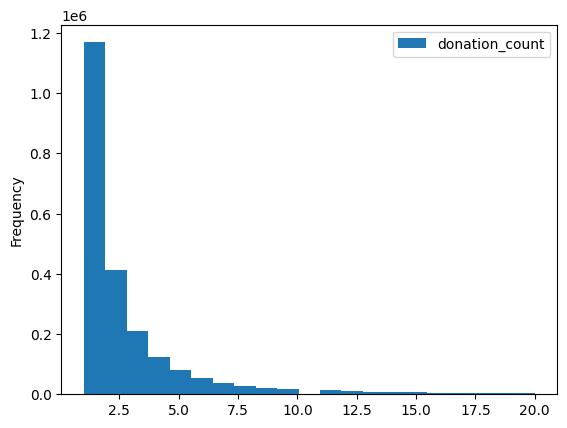

In [14]:
#Plot Histogram for the donation count to see the distribution
donor_donations[donor_donations['donation_count']<=20].plot(kind='hist', bins=21)

Since using histogram does not give much insights except there are a lot of people who are not a repeater for blood donation. Lets try using Pie Chart for two category one time donator and a repeater

In [15]:
#group the donor into repeater or not
repeater = []
for idx,val in enumerate(donor_donations['donation_count']):
    if val > 1:
        repeater.append(True)
    else:
        repeater.append(False)
donor_donations['repeater'] = repeater
donor_donations.head(10)

,donor_id,donation_count,repeater
0,00000,11,True
1,00001,4,True
2,00002,12,True
3,00003,5,True
4,00004,3,True
5,00005,9,True
6,00006,3,True
7,00007,15,True
8,00008,5,True
9,00009,19,True


([<matplotlib.patches.Wedge at 0x26e824fe6d0>,
 [Text(0.21526005846382334, 3.2929717744356926, 'Repeater'),
  Text(-0.21525975015355314, -3.292971794589779, 'One Time')],
 [Text(0.11741457734390362, 1.7961664224194682, '47.92%'),
  Text(-0.11741440917466534, -1.7961664334126064, '52.08%')])

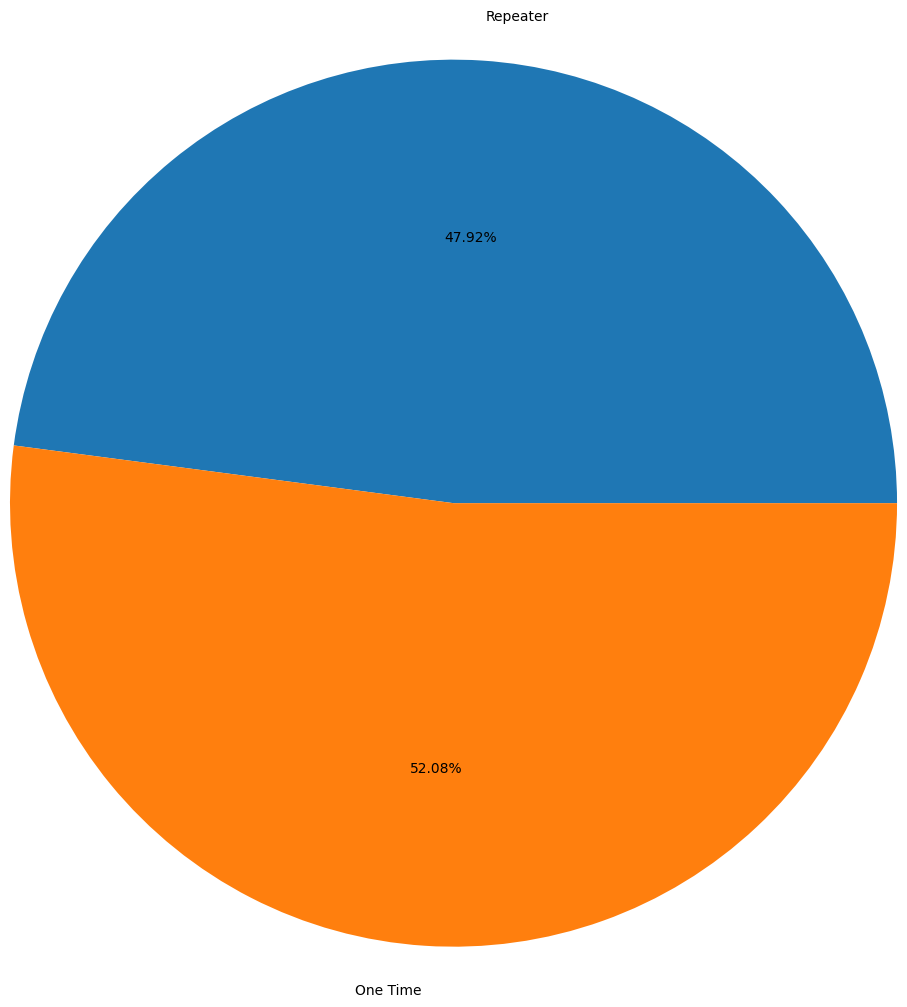

In [16]:
#Plot PieChart for repeater or not
one_time_count = donor_donations[donor_donations['repeater']==False]['repeater'].count()
repeater_count = donor_donations[donor_donations['repeater']==True]['repeater'].count()

fig,ax= plt.subplots()
label = ['Repeater','One Time']
sizes = [repeater_count,one_time_count]
ax.pie(sizes,labels=label,autopct='%1.2f%%',radius=3)


In [17]:
#Banding the donation_count
donor_donations[donor_donations['repeater']==True]['donation_count'].quantile(0.7)
first_group = donor_donations[(donor_donations['donation_count']>=2)&(donor_donations['donation_count']<=3)]['donation_count'].count()
second_group = donor_donations[(donor_donations['donation_count']>=4)&(donor_donations['donation_count']<=7)]['donation_count'].count()
third_group = donor_donations[(donor_donations['donation_count']>=8)]['donation_count'].count()

In [1]:
#Pie Chart for the group of Repeater
fig,ax= plt.subplots()
label = ['2-3','4-7','8+','1']
sizes = [first_group,second_group,third_group,one_time_count]
ax.pie(sizes,labels=label,autopct='%1.2f%%',radius=3)

NameError: name 'plt' is not defined

[None, None, None, None]

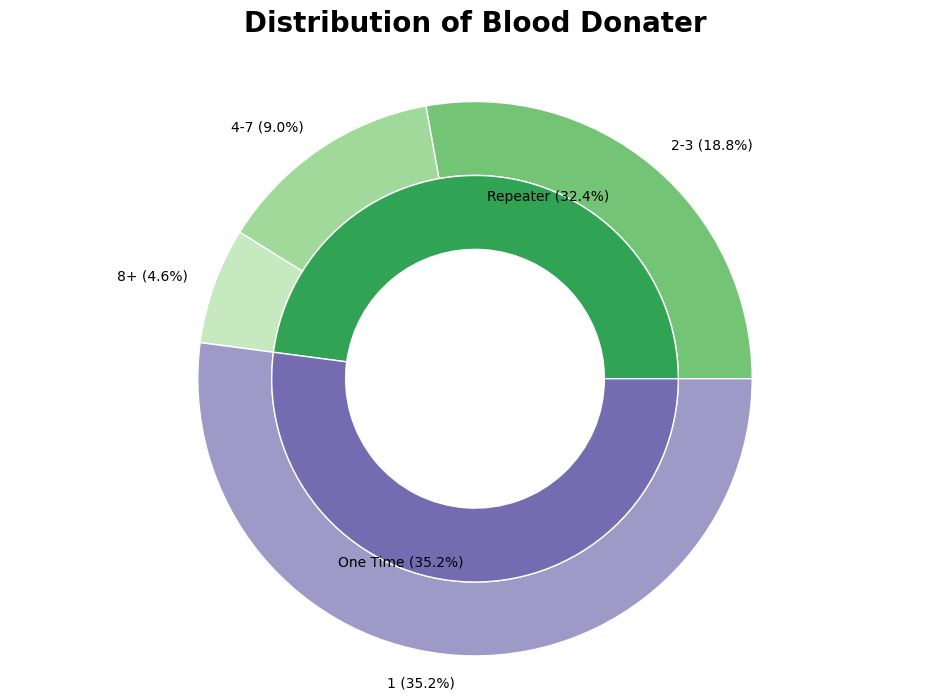

In [19]:
#Plot a two level Pie Chart
fig,ax = plt.subplots(figsize=(12,3))
ax.axis('equal')
width = 0.8

plt.text(0, 4, 'Distribution of Blood Donater', horizontalalignment='center', verticalalignment='top', fontsize=20, weight='bold')

#label and size for outer donut chart
size_out = [first_group,second_group,third_group,one_time_count]
label_out = ['2-3','4-7','8+','1']

#label and size for inner donut chart
label_in = ['Repeater','One Time']
sizes_in = [repeater_count,one_time_count]

# Calculate the total count for the calculation of percentages
total_count = sum(size_out) + sum(sizes_in) - one_time_count  # Subtract one_time_count since it's included twice

# Calculate the percentages for the outer ring
percentages_out = [f"{(size / total_count * 100):.1f}%" for size in size_out]

# Update labels for the outer ring with percentages
label_out_with_perc = [f"{label} ({perc})" for label, perc in zip(label_out, percentages_out)]

# Calculate the percentages for the inner ring
percentages_in = [f"{(size / total_count * 100):.1f}%" for size in sizes_in]

# Update labels for the inner ring with percentages
label_in_with_perc = [f"{label} ({perc})" for label, perc in zip(label_in, percentages_in)]


#Outer Ring (Donation Count Band)
cm = plt.get_cmap("tab20c")

cout = cm(np.array([9,10,11,13]))
pie, _ = ax.pie(size_out, radius=3, labels=label_out_with_perc, colors=cout)
plt.setp(pie, width=width, edgecolor='white',)

#Inner Ring (Repeater Or Not)
cin = cm(np.array([8,12]))
pie2, _ = ax.pie(sizes_in, radius=3-width, labels=label_in_with_perc,
                 labeldistance=0.9, colors=cin,rotatelabels=0)
plt.setp(pie2, width=width, edgecolor='white')

This is a good for a summary report but its not suitable for daily report. I will add for daily data.

In [20]:
#Getting all latest date donor
latest_date = max(sort_gran_fil['visit_date'])
latest_donor = sort_gran_fil[sort_gran_fil['visit_date']==latest_date]


In [33]:
#Using the donor_id get the number of donations they already did
donor_today = list(latest_donor['donor_id'])

donations_n = []
for id in donor_today:
    donations_n.append(donor_donations[donor_donations['donor_id'] == id]['donation_count'].values[0])

latest_donor['donations_count'] = donations_n
latest_donor.head(10)

C:\Users\adli\AppData\Local\Temp\ipykernel_24232\2015876622.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_donor['donations_count'] = donations_n


,donor_id,visit_date,birth_date,donor_age,donations_count
6243478,0018J,2024-01-22,1983,41,2
6243710,00202,2024-01-22,1970,54,15
6243449,002HE,2024-01-22,1995,29,3
6244010,003WU,2024-01-22,1989,35,5
6243719,0046f,2024-01-22,1981,43,4
6244068,004iy,2024-01-22,1966,58,9
6243742,004ng,2024-01-22,1973,51,13
6243987,0052w,2024-01-22,1973,51,17
6243726,0065z,2024-01-22,1979,45,6
6243499,007IY,2024-01-22,1989,35,8


In [40]:
latest_donor[latest_donor['donations_count']== 1]['donations_count'].count()

139

In [49]:
#Banding the donation_count
new_latest = latest_donor[latest_donor['donations_count']== 1]['donations_count'].count()
first_group_latest = latest_donor[(latest_donor['donations_count']>= 2)&(latest_donor['donations_count']<=3)]['donations_count'].count()
second_group_latest = latest_donor[(latest_donor['donations_count']>= 4)&(latest_donor['donations_count']<=7)]['donations_count'].count()
third_group_latest = latest_donor[(latest_donor['donations_count']>=8)]['donations_count'].count()

values = [new_latest,first_group_latest,second_group_latest,third_group_latest]
values
labels_latest = ['New Donator','2-3 Donations','4-7 Donations','8+ Donations']
labels_latest


['New Donator', '2-3 Donations', '4-7 Donations', '8+ Donations']

Text(0, 0.5, 'Group of Donators Based on Frequency')

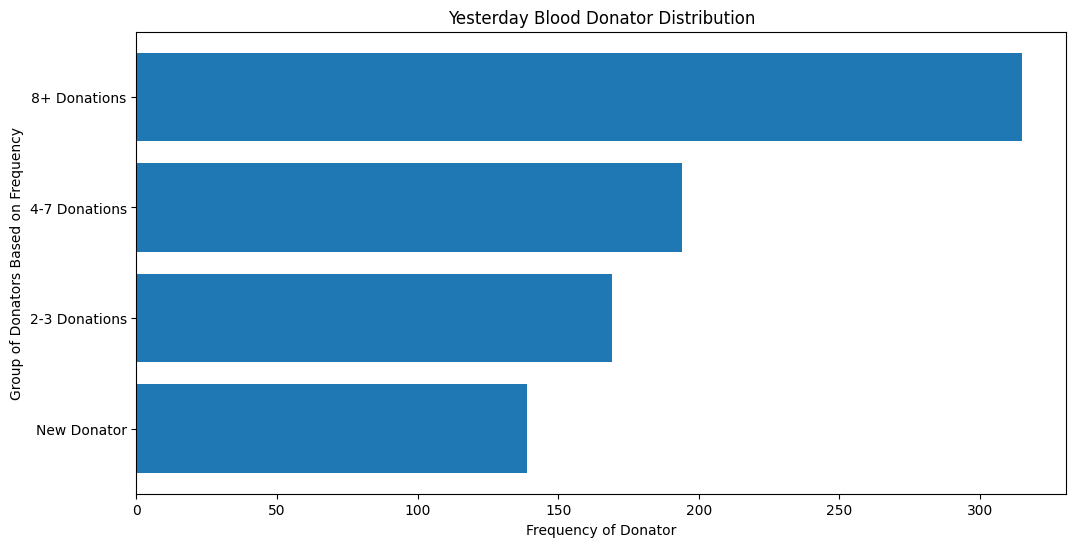

In [55]:
#plot Horizontal Bar for the latest donations frequency
fig,ax = plt.subplots(figsize=(12,6))
plt.barh(labels_latest,values),

plt.title('Yesterday Blood Donator Distribution')

plt.xlabel('Frequency of Donator')
plt.ylabel('Group of Donators Based on Frequency')